- https://www.kaggle.com/code/ihelon/rock-paper-scissors-agents-comparison
- https://github.com/Kaggle/kaggle-environments/blob/master/kaggle_environments/envs/rps/rps.json

In [ ]:
# !pip install kaggle-environments
# !pip install termcolor pygame chex

  Preparing metadata (setup.py) ... done
  Using cached jsonschema-4.23.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached referencing-0.35.1-py3-none-any.whl.metadata (2.8 kB)
INFO: pip is looking at multiple versions of shimmy to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 43.5 MB/s eta 0:00:00
Using cached jsonschema-4.23.0-py3-none-any.whl (88 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 87.7 MB/s eta 0:00:00
Using cached click-8.1.7-py3-none-any.whl (97 kB)
Using cached itsdangerous-2.2.0-py3-none-any.whl (16 kB)
Using cached referencing-0.35.1-py3-none-any.whl (26 kB)
   ━━━━━━━

In [3]:
# Подключаем нужные библиотеки
from kaggle_environments import make, evaluate
import numpy as np
import random
import collections
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Обозначения для ходов:
# 0 - камень
# 1 - бумага
# 2 - ножницы

# Создаем окружение для игры с заданным количеством шагов (ходов)
env = make("rps", configuration={"episodeSteps": 100})

Loading environment lux_ai_s3 failed: No module named 'gymnax'


In [4]:
%%writefile rock_agent.py
# Пишем агентов:

# 1. Агент, который всегда выбирает "камень"
def rock_agent(observation, configuration):
    """
    Агент, который всегда выбирает 'камень' (0).
    """
    return 0

Writing rock_agent.py


In [5]:
%%writefile paper_agent.py
# 2. Агент, который всегда выбирает "бумагу"
def paper_agent(observation, configuration):
    """
    Агент, который всегда выбирает 'бумагу' (1).
    """
    return 1

Writing paper_agent.py


In [6]:
%%writefile scissors_agent.py
# 3. Агент, который всегда выбирает "ножницы"
def scissors_agent(observation, configuration):
    """
    Агент, который всегда выбирает 'ножницы' (2).
    """
    return 2

Writing scissors_agent.py


In [7]:
%%writefile copy_opponent_agent.py
# 4. Агент, который копирует последний ход оппонента
import random
def copy_opponent_agent(observation, configuration):
    """
    Копирует последний ход противника. Если ход первый, выбирает случайно.
    """
    if observation.step > 0:
        return observation.lastOpponentAction  # копирует предыдущий ход противника
    else:
        return random.randrange(0, configuration.signs)  # случайный ход на первом шаге

Writing copy_opponent_agent.py


In [8]:
%%writefile reactionary_agent.py
# 5. Агент, который реагирует на последние действия противника
import random
import math

def get_score(left_move, right_move):
    """
    Вычисляет результат последнего действия. 
    Возвращает 0 при ничьей, 1 при выигрыше и -1 при проигрыше.
    """
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

last_react_action = None
def reactionary_agent(observation, configuration):
    """
    Агент реагирует на последние действия противника.
    Если предыдущий ход был проигран, выбирает новый ход.
    """
    global last_react_action
    if observation.step == 0:
        last_react_action = random.randrange(0, configuration.signs)  # случайный первый ход
    elif get_score(last_react_action, observation.lastOpponentAction) <= 1:
        last_react_action = (observation.lastOpponentAction + 1) % configuration.signs  # выбирает следующий ход

    return last_react_action

Writing reactionary_agent.py


In [9]:
%%writefile counter_reactionary_agent.py
# 6. Агент, который выбирает действие в зависимости от результатов последних ходов
import random
import math

last_counter_action = None
def get_score(left_move, right_move):
    """
    Возвращает счет на основе разницы между ходами.
    """
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

def counter_reactionary_agent(observation, configuration):
    """
    Если агент выиграл, выбирает действие, чтобы противодействовать.
    Иначе адаптируется к ходу противника.
    """
    global last_counter_action
    if observation.step == 0:
        last_counter_action = random.randrange(0, configuration.signs)  # случайный первый ход
    elif get_score(last_counter_action, observation.lastOpponentAction) == 1:
        last_counter_action = (last_counter_action + 2) % configuration.signs  # если выиграл, выбирает контр-ход
    else:
        last_counter_action = (observation.lastOpponentAction + 1) % configuration.signs  # выбирает ход противника + 1

    return last_counter_action

Writing counter_reactionary_agent.py


In [10]:
%%writefile statistical_agent.py
# 7. Агент, который анализирует статистику ходов противника
import random
action_histogram = {}
def statistical_agent(observation, configuration):
    """
    Запоминает ходы противника и выбирает действие, чтобы противодействовать
    наиболее частому ходу противника.
    """
    global action_histogram
    if observation.step == 0:
        action_histogram = {}  # очищает историю в начале
        return random.randint(0, 2)  # случайный ход в начале
    
    action = observation.lastOpponentAction
    action_histogram[action] = action_histogram.get(action, 0) + 1  # считает ходы противника

    mode_action = max(action_histogram, key=action_histogram.get)  # находит наиболее частый ход
    return (mode_action + 1) % configuration.signs  # возвращает контр-ход

Writing statistical_agent.py


In [11]:
%%writefile Jonson_agent.py
# 8. Агент Джонсона с анализом паттернов противника
import numpy as np
import collections
def Jonson_agent(observation, configuration):
    """
    Агент с анализом паттернов противника. Использует таблицу частот для предсказания.
    """
    k = 2
    global table, action_seq
    if observation.step % 25 == 0:
        action_seq, table = [], collections.defaultdict(lambda: [1, 1, 1])  # обновляет таблицу каждые 25 шагов
    if len(action_seq) <= 2 * k + 1:
        action = int(np.random.randint(3))
        if observation.step > 0:
            action_seq.extend([observation.lastOpponentAction, action])  # добавляет последний ход противника
        else:
            action_seq.append(action)
        return action

    key = ''.join([str(a) for a in action_seq[:-1]])  # ключ на основе последовательности ходов
    table[key][observation.lastOpponentAction] += 1  # обновляет таблицу по ключу

    action_seq[:-2] = action_seq[2:]
    action_seq[-2] = observation.lastOpponentAction
    key = ''.join([str(a) for a in action_seq[:-1]])
    
    if observation.step < 50:
        next_opponent_action_pred = np.argmax(table[key])  # предсказание по таблице
    else:
        scores = np.array(table[key])
        next_opponent_action_pred = np.random.choice(3, p=scores/scores.sum())
        
    action = (next_opponent_action_pred + 1) % 3
    if observation.step > 90:
        action = next_opponent_action_pred
    action_seq[-1] = action
    return int(action)

Writing Jonson_agent.py


In [12]:
%%writefile nash_equilibrium_agent.py
# 9. Агент по принципу равновесия Нэша (случайный выбор)
import random

def nash_equilibrium_agent(observation, configuration):
    """
    Случайный выбор действия для достижения равновесия Нэша.
    """
    return random.randint(0, 2)

Writing nash_equilibrium_agent.py


In [13]:
%%writefile rock_paper_agent.py
# 10. Агент, который случайно выбирает между "камнем" и "бумагой"
import random

def rock_paper_agent(observation, configuration):
    """
    Случайно выбирает между 'камнем' (0) и 'бумагой' (1).
    """
    return random.randint(0, 1)

Writing rock_paper_agent.py


In [14]:
%%writefile paper_scissors_agent.py
# 11. Агент, который случайно выбирает между "бумагой" и "ножницами"
import random

def paper_scissors_agent(observation, configuration):
    """
    Случайно выбирает между 'бумагой' (1) и 'ножницами' (2).
    """
    return random.randint(1, 2)

Writing paper_scissors_agent.py


In [15]:
%%writefile rock_scissors_agent.py
# 12. Агент, который случайно выбирает между "камнем", "ножницами" и "бумагой"
import random

def rock_scissors_agent(observation, configuration):
    """
    Случайно выбирает 'камень' (0), 'ножницы' (2) или 'бумагу' (1).
    """
    return random.randint(0, 2)

Writing rock_scissors_agent.py


In [16]:
%%writefile transition_agent.py
# 13. Агент с матрицей переходов для предсказания действий противника
import numpy as np
import pandas as pd
import random

T = np.zeros((3, 3))
P = np.zeros((3, 3))

a1, a2 = None, None

def transition_agent(observation, configuration):
    """
    Агент анализирует переходы между действиями противника и предсказывает следующее.
    """
    global T, P, a1, a2
    if observation.step > 1:
        a1 = observation.lastOpponentAction
        T[a2, a1] += 1  # обновляет матрицу переходов
        P = np.divide(T, np.maximum(1, T.sum(axis=1)).reshape(-1, 1))
        a2 = a1
        if np.sum(P[a1, :]) == 1:
            return int((np.random.choice([0, 1, 2], p=P[a1, :]) + 1) % 3)  # предсказание на основе вероятностей
        else:
            return int(np.random.randint(3))  # случайный ход
    else:
        if observation.step == 1:
            a2 = observation.lastOpponentAction
        return int(np.random.randint(3))

Writing transition_agent.py


In [17]:
# Турнир между агентами
agents = ['rock_agent', 'paper_agent', 'scissors_agent',
          'copy_opponent_agent', 'reactionary_agent', 
          'counter_reactionary_agent', 'statistical_agent',
          'Jonson_agent', 'nash_equilibrium_agent',
          'rock_paper_agent', 'paper_scissors_agent',
          'rock_scissors_agent', 'transition_agent']

# Добавляем .py к каждому агенту
agents_py = [i + ".py" for i in agents]
n_agents = len(agents)

# Инициализируем матрицу результатов
scores = np.zeros((n_agents, n_agents))

# Играем каждый агент против каждого
for i in range(n_agents):
    for j in range(i + 1, n_agents):
        result = evaluate("rps", [agents_py[i], agents_py[j]], configuration={"episodeSteps": 100}, num_episodes=1)
        scores[i][j] = result[0][0]  # сохраняем результат для агента i
        scores[j][i] = result[0][1]  # сохраняем результат для агента j

# Определяем победителя
vic = []
for i in range(n_agents):
    cnt_vic = sum(1 for j in range(n_agents) if scores[i][j] > 0)  # считаем победы агента
    vic.append(cnt_vic)

# Определяем индексы победителей
i_victors = [i for i, v in enumerate(vic) if v == max(vic)]
if len(i_victors) > 1:
    print("The winners are", '\n', *[agents_py[i] for i in i_victors], "!")
else:
    print("The winner is", agents_py[i_victors[0]], "!")

The winner is transition_agent.py !


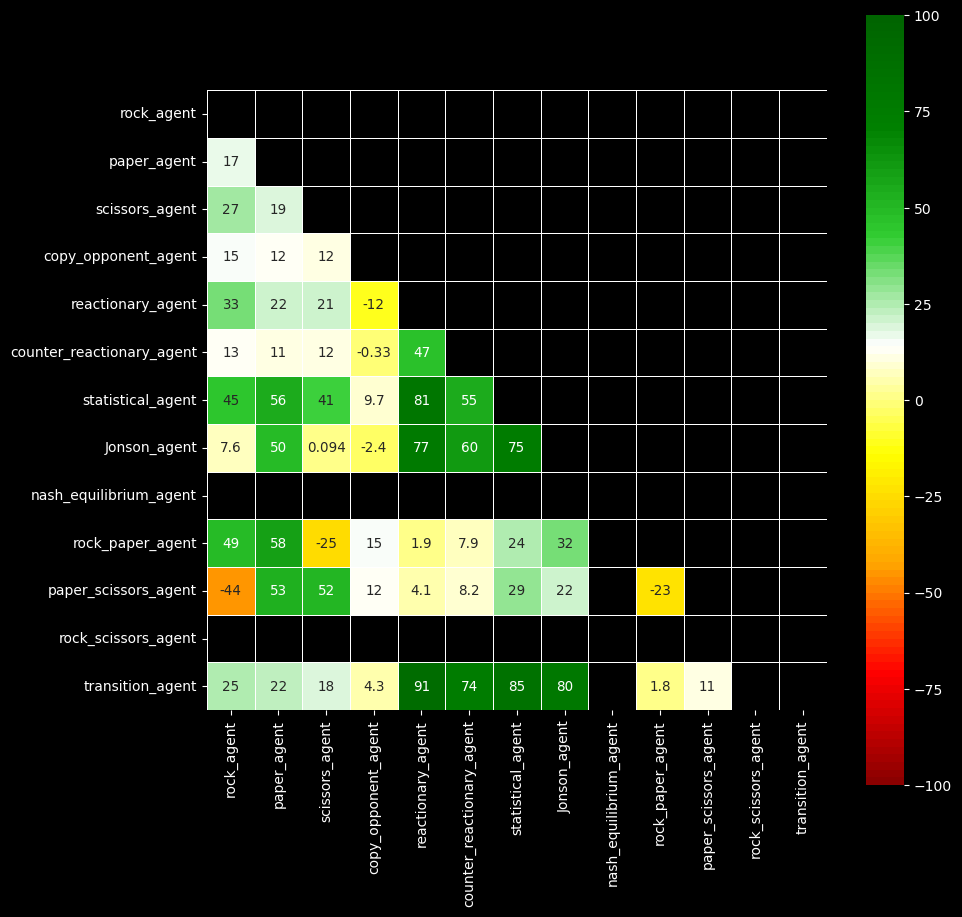

In [22]:
# Построение матрицы корреляций
df_scores = pd.DataFrame(scores, index=agents, columns=agents)
df_scores

# # Построение дополнительной визуализации
import math
from matplotlib.colors import LinearSegmentedColormap

cmatrix = df_scores.corr() * 100
cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['crimson', 'yellow', 'yellowgreen', 'yellow'], 20)
# Более контрастная цветовая палитра
contrast_cmap = LinearSegmentedColormap.from_list(
    'ContrastCmap', 
    ['darkred', 'red', 'orange', 'yellow', 'white', 'limegreen', 'green', 'darkgreen'], 
    N=100
)
mask = np.triu(np.ones(cmatrix.shape[0]), k=0)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(ax=ax, data=cmatrix, cmap=contrast_cmap, vmin=-100, vmax=100, linewidths=.5, square=True, annot=True, mask=mask, annot_kws={'size':35 / math.sqrt(cmatrix.shape[0])})
plt.show()

In [23]:
# Подключаем нужные библиотеки
from kaggle_environments import make, evaluate
import numpy as np
import random
import collections
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Создаем окружение для игры с заданным количеством шагов (ходов)
env = make("rps", configuration={"episodeSteps": 100})

# Здесь загружаем созданных агентов
# (предполагается, что файлы агентов уже созданы, как показано ранее)

# Дополнительные эксперименты: запуск определенных агентов против друг друга

# 1. Запускаем игру между агентом transition_agent и агентом rock
env.run(["transition_agent.py", "rock_agent.py"])
env.render(mode="ipython", width=500, height=400)
print("Результат transition_agent против rock:", evaluate("rps", ["Jonson_agent.py", "rock_agent.py"], configuration={"episodeSteps": 1000}))

# 2. Запускаем игру между агентом transition_agent и copy_opponent
env.run(["transition_agent.py", "copy_opponent_agent.py"])
env.render(mode="ipython", width=500, height=400)
print("Результат transition_agent против copy_opponent:", evaluate("rps", ["transition_agent.py", "copy_opponent_agent.py"], configuration={"episodeSteps": 1000}))

# 3. Запускаем игру между агентом transition_agent и statistical_agent
env.run(["transition_agent.py", "statistical_agent.py"])
env.render(mode="ipython", width=500, height=400)
print("Результат transition_agent против statistical_agent:", evaluate("rps", ["transition_agent.py", "statistical_agent.py"], configuration={"episodeSteps": 1000}))

# 4. Запускаем игру между двумя агентами transition_agent
env.run(["transition_agent.py", "transition_agent.py"])
env.render(mode="ipython", width=500, height=400)
print("Результат transition_agent против transition_agent:", evaluate("rps", ["transition_agent.py", "transition_agent.py"], configuration={"episodeSteps": 1000}))

Результат transition_agent против rock: [[0, 0]]


Результат transition_agent против copy_opponent: [[-36.0, 36.0]]


Результат transition_agent против statistical_agent: [[392.0, -392.0]]


Результат transition_agent против transition_agent: [[0, 0]]


In [24]:
# 5. Запускаем игру между агентами transition и reactionary
env.run(["transition_agent.py", "reactionary_agent.py"])
env.render(mode="ipython", width=500, height=400)
print("Результат transition_agent против reactionary_agent:", evaluate("rps", ["transition_agent.py", "reactionary_agent.py"], configuration={"episodeSteps": 1000}))

Результат transition_agent против reactionary_agent: [[29.0, -29.0]]
